# Sunrise Demo

## Setup

In [19]:
# %load init.py
#@title Import & Utilities
from __future__ import annotations

class AutoImportError(ImportError):
    pass

class auto(object):
    registry: ClassVar[Dict[str, Tuple[str, ...]]] = {}

    @classmethod
    def register(
        cls,
        import_name: str,
        package_name: Optional[str]=None,
        *extra_package_names: List[str],
    ):
        if package_name is None:
            package_name = import_name

        cls.registry[import_name] = (
            package_name,
            *extra_package_names,
        )

    def __getattr__(self, import_name: str):
        import subprocess, importlib, sys

        try:
            return object.__getattribute__(self, import_name)
        except AttributeError:
            pass

        module = None
        try:
            module = importlib.import_module(import_name)
        except ImportError as e:
            package_names = self.registry[import_name]

            process = subprocess.run([
                sys.executable,
                '-m', 'pip',
                'install',
                *package_names,
            ], stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)

            if process.returncode != 0:
                raise AutoImportError(f"Failed to pip install {package_names!r}\n\n{process.stdout.read()}") from e

            try:
                module = importlib.import_module(import_name)
            except ImportError as e:
                raise AutoImportError(f'Import failed a second time, even after a pip install') from e

        assert module is not None
        # print(f'setattr({self!r}, {import_name!r}, {module!r})')
        setattr(self, import_name, module)
        return module

auto.register('tqdm')
auto.register('more_itertools', 'more-itertools')
auto.register('torch')
auto.register('peft')
auto.register('guidance')
auto.register('langchain')
auto.register('diffusers')

auto.register('transformers', None, 'transformers', 'accelerate', 'datasets', 'tokenizers', 'evaluate', 'huggingface_hub', 'torch')
auto.register('accelerate', None, 'transformers', 'accelerate', 'datasets', 'tokenizers', 'evaluate', 'huggingface_hub', 'torch')
auto.register('datasets', None, 'transformers', 'accelerate', 'datasets', 'tokenizers', 'evaluate', 'huggingface_hub', 'torch')
auto.register('tokenizers', None, 'transformers', 'accelerate', 'datasets', 'tokenizers', 'evaluate', 'huggingface_hub', 'torch')
auto.register('evaluate', None, 'transformers', 'accelerate', 'datasets', 'tokenizers', 'evaluate', 'huggingface_hub', 'torch')
auto.register('huggingface_hub', None, 'transformers', 'accelerate', 'datasets', 'tokenizers', 'evaluate', 'huggingface_hub', 'torch')

auto = auto()


def doctest(func=None, /, verbose=False, sterile=False):
    def wrapper(func):
        # Thanks https://stackoverflow.com/a/49659927
        import doctest, copy

        # I need this to error out on failure; the default one doesn't.
        def run_docstring_examples(f, globs, verbose=False, name="NoName", compileflags=None, optionflags=0):
            finder = doctest.DocTestFinder(verbose=verbose, recurse=False)
            runner = doctest.DocTestRunner(verbose=verbose, optionflags=optionflags)
            for test in finder.find(func, name, globs=globs):
                runner.run(test, compileflags=compileflags)
            assert runner.failures == 0

        name = func.__name__

        if sterile:
            globs = {}
        else:
            globs = copy.copy(globals())
        globs[name] = func
        run_docstring_examples(func, globs, verbose=verbose, name=name)
        return func

    if func is not None:
        return wrapper(func)
    else:
        return wrapper

try:
    g
except NameError:
    g = {}

try:
    f
except NameError:
    f = {}

def run(func=None, /, name=None, cond=True, splat=False, after=None, scope=None):
    def wrapper(func, /, *, name=name, cond=cond):
        import inspect

        if callable(cond):
            cond = cond()

        if not cond:
            return None

        if name is None:
            name = func.__name__
            
        f[name] = func

        args = []
        for key, parameter in inspect.signature(func).parameters.items():
            if parameter.kind == inspect.Parameter.POSITIONAL_ONLY:
                keys = [key]
                if scope is not None:
                    keys.insert(0, f'{scope}__{key}')
                
                for key in keys:
                    try:
                        value = g[key]
                    except KeyError:
                        continue
                    else:
                        args.append(value)
                        break
                else:
                    raise KeyError(f'None of {keys=!r} found in g')

        ret = func(*args)

        if callable(after):
            after(ret)

        if splat:
            it = ret.items()
        else:
            it = [(name, ret)]

        for name, ret in it:
            if scope is not None:
                name = f'{scope}__{name}'

            g[name] = ret

        return None

    if func is not None:
        return wrapper(func)
    else:
        return wrapper

@auto.IPython.core.magic.register_line_magic
@auto.IPython.core.magic.register_cell_magic
def source(magic_line, magic_cell=None):
    import os, subprocess, shlex

    if magic_cell is None or magic_cell == '':
        before = os.environ.copy()

        process = subprocess.run([
            'bash', '-c', f'source {magic_line}; export',
        ], capture_output=True, text=True)

        after = {}
        for line in process.stdout.split('\n'):
            if line == '': continue
            parts = shlex.split(line)
            assert parts[0] == 'declare', f'{line=!r}'
            assert parts[1] == '-x', f'{line=!r}'
            if '=' not in parts[2]: continue
            name, value = parts[2].split('=', 1)

            if before.get(name, None) == value: continue
            after[name] = value

        magic_cell = f'%%source {magic_line}\n'
        magic_cell += f'os.environ |= {{\n'
        for name, value in after.items():
            magic_cell += f'  {name!r}: '
            if ':' in value:
                magic_cell += f'":".join([\n'
                for value in value.split(':'):
                    magic_cell += f'    {value!r},\n'
                magic_cell += f'  ]),\n'
            else:
                magic_cell += f' {value!r},\n'
        magic_cell += f'}}\n'

        get_ipython().set_next_input(magic_cell, replace=True)

    get_ipython().run_cell(magic_cell)

In [102]:
Degree = auto.typing.NewType('Degree', float)
Radian = auto.typing.NewType('Radian', float)
Meter = auto.typing.NewType('Meter', float)
Kilometer = auto.typing.NewType('Kilometer', float)

In [101]:
def convert_location_to_spatial(
    *,
    lat: Degree,
    lng: Degree,
    alt: Meter,
    radians=auto.math.radians,
    cos=auto.math.cos,
    sin=auto.math.sin,
) -> Tuple[Meter, Meter, Meter]:
    # Thanks https://gis.stackexchange.com/a/4148
    
    #> Note that "Lat/Lon/Alt" is just another name for spherical coordinates, and 
    #> phi/theta/rho are just another name for latitude, longitude, and altitude.
    #> :) (A minor difference: altitude is usually measured from the surface of the 
    #> sphere; rho is measured from the center -- to convert, just add/subtract the 
    #> radius of the sphere.)
    phi: Radian = radians(lat)
    theta: Radian = radians(lng)
    
    # Thanks https://en.wikipedia.org/wiki/Earth_radius
    #> A globally-average value is usually considered to be 6,371 kilometres (3,959 mi)
    rho: Meter = 6_371_000 + alt
    
    #> x = math.cos(phi) * math.cos(theta) * rho
    x: Meter = cos(phi) * cos(theta) * rho
    
    #> y = math.cos(phi) * math.sin(theta) * rho
    y: Meter = cos(phi) * sin(theta) * rho

    #> z = math.sin(phi) * rho # z is 'up'
    z: Meter = sin(phi) * rho
    
    #> (Note there's some slightly arbitrary choices here in what each axis means...
    #> you might want 'y' to point at the north pole instead of 'z', for example.)
    
    # I do :)
    y, z = z, y
    
    return x, y, z

In [93]:
@doctest
def convert_tile_coordinates_to_latlng(*, z: int, x: int, y: int, return_google_maps_url: bool=False) -> Tuple[Degree, Degree]:
    r"""
    
    >>> convert_tile_coordinates_to_latlng(z=15, x=8739, y=12925, return_google_maps_url=True)
    'https://www.google.com/maps/@35.48751102385376,-83.990478515625,15.79z?entry=ttu'
    
    """
    
    # Thanks https://gis.stackexchange.com/a/133535
    
    # n = 2 ^ zoom
    n = 2 ** z
    
    # lon_deg = xtile / n * 360.0 - 180.0
    lon_deg = x / n * 360.0 - 180.0
    
    # lat_rad = arctan(sinh(π * (1 - 2 * ytile / n)))
    lat_rad = auto.math.atan(auto.math.sinh(auto.math.pi * (1.0 - 2.0 * y / n)))
    
    # lat_deg = lat_rad * 180.0 / π
    lat_deg = lat_rad * 180.0 / auto.math.pi
    
    if return_google_maps_url:
        return f"""https://www.google.com/maps/@{lat_deg},{lon_deg},15.79z?entry=ttu"""
    
    return lat_deg, lon_deg

In [94]:
@auto.dataclasses.dataclass(eq=True, order=True, frozen=True)
class Coord:
    """Tile image coordinates for mapbox/etc services"""
    z: int
    x: int
    y: int

    @property
    def nw(self) -> Location:
        """North-West lat/lng of current tile"""
        lat, lng = tile_coordinates_to_latlng(
            z=self.z,
            x=self.x,
            y=self.y,
        )
        return Location(lat=lat, lng=lng)

    @property
    def se(self) -> Location:
        """South-East lat/lng of current tile"""
        lat, lng = tile_coordinates_to_latlng(
            z=self.z,
            x=1+self.x,
            y=1+self.y,
        )
        return Location(lat=lat, lng=lng)

@auto.dataclasses.dataclass(eq=True, frozen=True)
class Domain:
    """Lower (inclusive) and upper (inclusive) bounds of latitude/longitude"""
    lo: Coord
    hi: Coord
        
    @property
    def coords(self) -> List[Coord]:
        """All coordinates within lower/upper bounds"""
        coords = []
        for z, x, y in auto.itertools.product(
            range(self.lo.z, 1+self.hi.z),
            range(self.lo.x, 1+self.hi.x),
            range(self.lo.y, 1+self.hi.y),
        ):
            coords.append(Coord(
                z=z,
                x=x,
                y=y,
            ))
        
        return coords

@auto.dataclasses.dataclass(eq=True, order=True, frozen=True)
class Location:
    """Geographical latitude/longitude"""
    lat: float
    lng: float
    alt: Optional[float] = auto.dataclasses.field(default=None)

@auto.dataclasses.dataclass(eq=True, order=True, frozen=True)
class Point:
    x: float
    y: float
    z: float

In [2]:
@auto.dataclasses.dataclass
class TileURL:
    scheme: str
    netloc: str
    prefix: str
    z: int
    x: int
    y: int
    suffix: str
    query: Dict[str, str]
    fragment: str

    @classmethod
    @doctest
    def decode(cls, url: str) -> Self:
        r"""
        
        >>> decode(dict, 'https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg')
        ... # doctest: +NORMALIZE_WHITESPACE
        {'scheme': 'https',
         'netloc': 'atlas-stg.geoplatform.gov',
         'prefix': ['', 'styles', 'v1', 'atlas-user', 'ck58pyquo009v01p99xebegr9', 'tiles', '256'],
         'z': 11,
         'x': 549,
         'y': 806,
         'suffix': '@2x',
         'query': [('access_token',
                    'pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg')],
         'fragment': ''}
        >>> decode(dict, 'https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/549/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg')
        ... # doctest: +NORMALIZE_WHITESPACE
        {'scheme': 'https',
         'netloc': 'atlas-stg.geoplatform.gov:443',
         'prefix': ['', 'v4', 'atlas-user.0000214_pink'],
         'z': 11,
         'x': 549,
         'y': 806,
         'suffix': '.png',
         'query': [('access_token',
                    'pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg')],
         'fragment': ''}
        
        """
        
        scheme, netloc, path, query, fragment = auto.urllib.parse.urlsplit(
            url,
        )
        path = path.split('/')
        *prefix, z, x, suffix = path
        assert (match := auto.re.match(r'^(\d+)(.*)$', suffix)) is not None, \
            f'{suffix = !r}'
        y, suffix = match.groups()
            
        
        z, x, y = map(int, (z, x, y))
        query = auto.urllib.parse.parse_qsl(
            query,
        )

        return cls(
            scheme=scheme,
            netloc=netloc,
            prefix=prefix,
            z=z,
            x=x,
            y=y,
            suffix=suffix,
            query=query,
            fragment=fragment,
        )

    def encode(self) -> str:
        query = auto.urllib.parse.urlencode(
            self.query,
            doseq=True,
        )
        
        z, x, y = map(str, (self.z, self.x, self.y))

        path = '/'.join([
            *self.prefix,
            z,
            x,
            y + self.suffix,
        ])

        return auto.urllib.parse.urlunsplit((
            self.scheme,
            self.netloc,
            path,
            query,
            self.fragment,
        ))

In [64]:
@run(after=auto.pprint.pp, scope='background')
def domain():
    from bs4 import BeautifulSoup
    
    soup = BeautifulSoup(r'''
        <img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 237px, 0px); opacity: 1;">
        <img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -275px, 0px); opacity: 1;">
        <img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 493px, 0px); opacity: 1;">
    ''', 'html.parser')
    
    urls = []
    for img in soup('img'):
        src = img['src']
        url = TileURL.decode(src)
        urls.append(url)
    
    return Domain(
        lo=Coord(
            z=min(url.z for url in urls),
            x=min(url.x for url in urls),
            y=min(url.y for url in urls),
        ),
        hi=Coord(
            z=max(url.z for url in urls),
            x=max(url.x for url in urls),
            y=max(url.y for url in urls),
        ),
    )

Domain(lo=Coord(z=11, x=546, y=805), hi=Coord(z=11, x=551, y=808))


In [65]:
@run(cond='cache' not in g)
def cache():
    return {}

@run
def cache(cache, /):
    def load() -> Dict:
        ret = {}
        try:
            with open(path, 'rb') as f:
                ret = auto.pickle.load(f)
                print(f'Read {f.tell():,d} bytes from {path}')
        except Exception as e:
            print('load failed:')
            auto.traceback.print_exception(e)
        
        return ret
    
    def merge(mutable: Dict, constant: Dict):
        try:
            for k, v in constant.items():
                if k in mutable:
                    continue

                mutable[k] = v
        except Exception as e:
            print('merge failed:')
            auto.traceback.print_exception(e)
    
    def dump(d: Dict):
        try:
            with open(path, 'wb') as f:
                auto.pickle.dump(d, f)

                print(f'Wrote {f.tell():,d} bytes to {path}')
        except Exception as e:
            print('dump failed:')
            auto.traceback.print_exception(e)
        
    path = auto.pathlib.Path.home() / 'Downloads' / 'Sunrise Demo Cache.pickle'
    
    if path.exists():
        merge(cache, load())
    
    dump(cache)
    
    return cache

Read 14,473,734 bytes from /home/thobson/Downloads/Sunrise Demo Cache.pickle
Wrote 14,473,734 bytes to /home/thobson/Downloads/Sunrise Demo Cache.pickle


In [66]:
@run
def fetch(cache, /):
    import requests
    
    def fetch(url: str, *, tqdm=None) -> bytes:
        key = url
        if key not in cache:
            if tqdm is not None:
                tqdm.set_description(f'Cache Miss: {url}')

            with requests.get(url) as r:
                cache[key] = r.content
            
            auto.time.sleep(1)
        
        else:
            if tqdm is not None:
                tqdm.set_description('Cache Hit: {url}')
        
        return cache[key]

    return fetch

In [67]:
@auto.dataclasses.dataclass(eq=True, frozen=True)
class Tile:
    coord: Coord
    url: str = auto.dataclasses.field(repr=False)
    image: bytes = auto.dataclasses.field(repr=False)

@run(scope='background', after=lambda x: print(len(x)))
def tiles(domain, fetch, /):
    def make_url(coord: Coord, /, *, url=TileURL.decode(
        r"""https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg"""
    )):
        return auto.dataclasses.replace(
            url,
            z=coord.z,
            x=coord.x,
            y=coord.y,
        )
    
    tiles = []
    for coord in (tqdm := auto.tqdm.tqdm(domain.coords)):
        url = make_url(coord).encode()
        image = fetch(url, tqdm=tqdm)

        tiles.append(Tile(
            coord=coord,
            url=url,
            image=image,
        ))

    return tiles

Cache Hit: {url}: 100%|██████████| 24/24 [00:00<00:00, 1068.91it/s]

24


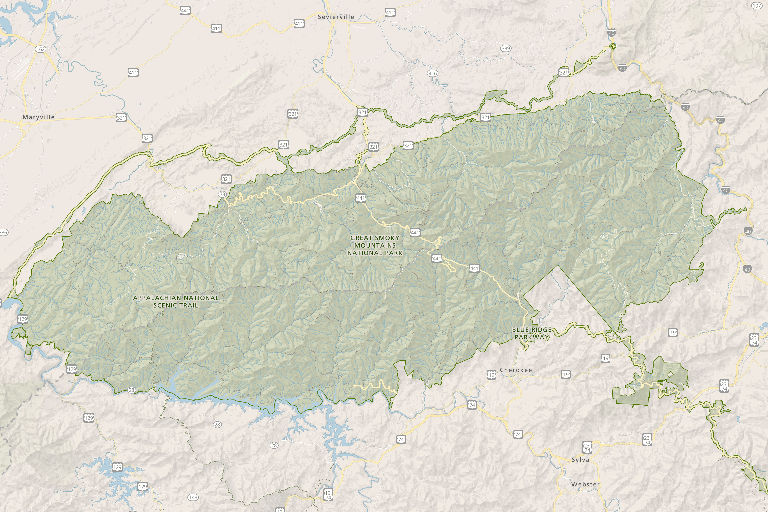

In [68]:
auto.register('PIL', 'Pillow')

@run(scope='background', after=auto.IPython.display.display)
def __stitch_tiles(tiles, /):
    auto.PIL; from PIL import Image
    
    xs = set(tile.coord.x for tile in tiles)
    ys = set(tile.coord.y for tile in tiles)
    
    xs = sorted(xs)
    ys = sorted(ys)
    
    nx = len(xs)
    ny = len(ys)
    
    sz = 128
    
    composite = Image.new('RGB', (nx*sz, ny*sz))
    
    for tile in tiles:
        xi = xs.index(tile.coord.x)
        yi = ys.index(tile.coord.y)
        
        with auto.io.BytesIO(tile.image) as f:
            try:
                image = Image.open(f)
            except auto.PIL.UnidentifiedImageError:
                continue

            image.thumbnail((sz, sz))

        composite.paste(image, (xi*sz, yi*sz))
    
    return composite

In [69]:
@run(scope='elevation')
def domain(background__domain, /):
    return background__domain

@run(scope='elevation')
def tiles(domain, fetch, /):
    def make_url(coord: Coord, /, *, url=TileURL.decode(
        r"""https://api.mapbox.com/v4/mapbox.terrain-rgb/14/3826/6127@2x.pngraw?access_token=pk.eyJ1IjoidGhvYnNvbjIiLCJhIjoiY2oxZmdqbnQzMDBpbjJxczR6dWoyemUxNiJ9.SEBHSdHLP_lZGD43r-_IDQ"""
    )) -> URL:
        return auto.dataclasses.replace(
            url,
            z=coord.z,
            x=coord.x,
            y=coord.y,
        )
    
    tiles = []
    for coord in (tqdm := auto.tqdm.tqdm(domain.coords)):
        url = make_url(coord).encode()
        image = fetch(url, tqdm=tqdm)
        
        tiles.append(Tile(
            coord=coord,
            url=url,
            image=image,
        ))
    
    return tiles

Cache Hit: {url}: 100%|██████████| 24/24 [00:00<00:00, 775.48it/s]


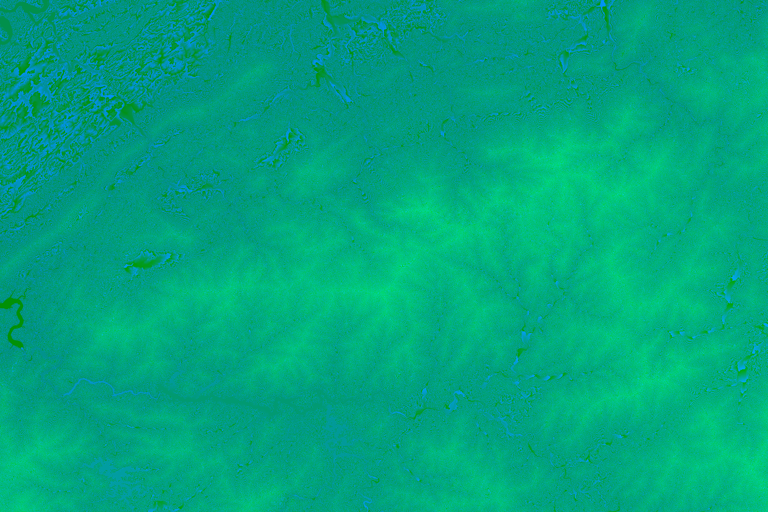

In [70]:
f['__stitch_tiles'](g['elevation__tiles'])

In [71]:
@auto.dataclasses.dataclass(eq=True, frozen=True)
class Observation:
    common_name: str
    irma_id: str
    latin_name_ref: str
    latin_name: str

@run
def observations(fetch, /):
    observations = []
    for observation in (
        Observation(**kwargs)
        for kwargs in (
            auto.json.loads(fetch('https://species.atlasofthesmokies.org/atbirecords/lexical_index.json'))
        )['items']
    ):
        observations.append(observation)
    
    return observations

In [72]:
@run(after=print)
def observation(observations, /):
    for observation in observations:
        if observation.common_name not in [
            'A Spiny Crawler Mayfly',
            'Acadian Flycatcher',
            'Agreeable Tiger Moth',
        ]:
            continue
        
        return observation

Observation(common_name='Acadian Flycatcher', irma_id='0013547', latin_name_ref='Empidonax virescens', latin_name='Empidonax_virescens')


In [73]:
@run(scope='observation', after=print)
def domain():
    from bs4 import BeautifulSoup
    
    soup = BeautifulSoup('''
    <img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/548/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/547/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/548/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/549/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/549/805.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/546/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/549/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/550/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/550/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 237px, 0px); opacity: 1;">
    <img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/548/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/547/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/548/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/549/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/549/805.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/546/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/549/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/550/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/550/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/551/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/551/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 493px, 0px); opacity: 1;">
    <img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/548/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/549/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/548/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/549/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/547/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/550/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/547/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/550/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/546/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/551/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/546/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/551/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/548/808.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/549/808.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/547/808.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/546/808.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 493px, 0px); opacity: 1;">
    ''', 'html.parser')
    
    urls = []
    for img in soup('img'):
        src = img['src']
        try:
            url = TileURL.decode(src)
        except:
#             print(f'Bad! {src=!r}')
            pass
        else:
            urls.append(url)
    
    return Domain(
        lo=Coord(
            z=min(url.z for url in urls),
            x=min(url.x for url in urls),
            y=min(url.y for url in urls),
        ),
        hi=Coord(
            z=max(url.z for url in urls),
            x=max(url.x for url in urls),
            y=max(url.y for url in urls),
        ),
    )

Domain(lo=Coord(z=11, x=546, y=805), hi=Coord(z=11, x=551, y=808))


In [74]:
@run(scope='observation')
def tiles(domain, observation, fetch, /):
    def make_url(coord: Coord, /, *, url=TileURL.decode(
        r"""https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/546/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg"""
    )) -> TileURL:
        return auto.dataclasses.replace(
            url,
            prefix=['v4', f'atlas-user.{observation.irma_id}_pink'],
            z=coord.z,
            x=coord.x,
            y=coord.y,
        )
    
    tiles = []
    for coord in (tqdm := auto.tqdm.tqdm(domain.coords)):
        url = make_url(coord).encode()
        image = fetch(url, tqdm=tqdm)
        if image == b'{"message":"Tile does not exist"}':
            continue
        
        tiles.append(Tile(
            coord=coord,
            url=url,
            image=image,
        ))
    
    return tiles

Cache Hit: {url}: 100%|██████████| 24/24 [00:00<00:00, 1227.87it/s]


/home/thobson/.local/lib/python3.10/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


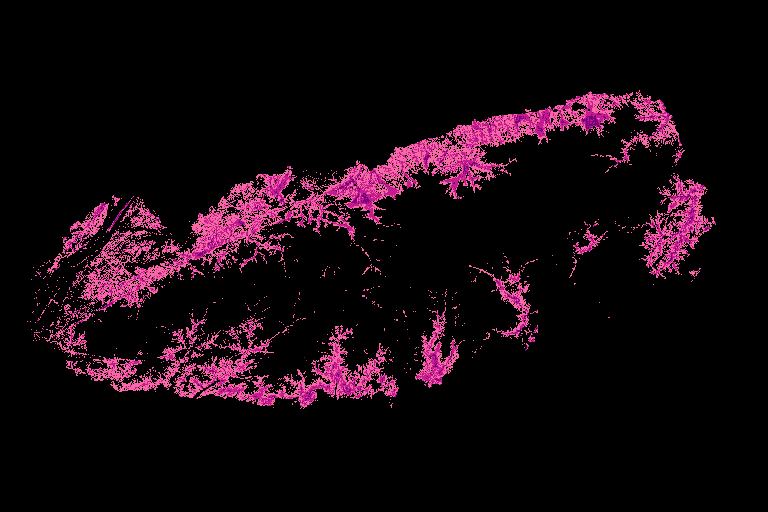

In [75]:
f['__stitch_tiles'](g['observation__tiles'])

In [76]:
@run(scope='observation')
def __estimate_data_sizes(tiles, /):
    from PIL import Image
    
    nx = len(set(tile.coord.x for tile in tiles))
    ny = len(set(tile.coord.y for tile in tiles))
    
    for tile in tiles:
        with auto.io.BytesIO(tile.image) as f:
            image = Image.open(f)
            image.load()

            width = image.width
            height = image.height

            assert width == height, \
                f'non-square {width=} {height=}'

    resolution = width
    x_resolution = nx*resolution
    y_resolution = ny*resolution
    print(f"""For an 2D RGB texture of uint8_t of size {x_resolution:,d}x{y_resolution:,d}:""")
    texture_bytes = 4 * x_resolution * y_resolution
    print(f"""  the file would be {texture_bytes:,d} bytes""")
    
    print(f"""For a triangle mesh:""")
    n_vertices = (1+x_resolution) * (1+y_resolution)
    print(f"""  number of vertices = {n_vertices:,d} ({3*4*n_vertices:,d} bytes of vec3f data)""")
    n_edges = x_resolution * y_resolution * 3
    print(f"""  number of edges = {n_edges:,d} ({3*4*n_edges:,d} bytes of vec3ui data)""")

For an 2D RGB texture of uint8_t of size 1,536x1,024:
  the file would be 6,291,456 bytes
For a triangle mesh:
  number of vertices = 1,575,425 (18,905,100 bytes of vec3f data)
  number of edges = 4,718,592 (56,623,104 bytes of vec3ui data)


In [100]:
@auto.dataclasses.dataclass(eq=True, frozen=True)
class Elevation:
    domain: Domain
    altitude: auto.numpy.ndarray[tuple[Any, Any], np.float32]
    latlng: auto.numpy.ndarray[tuple[Any, Any, Literal[2]], np.float32]

@run(scope='elevation', after=print)
def elevation(domain, tiles, /):
    from PIL import Image
    np = auto.numpy
    
    def tile_altitude(tile: Tile, /) -> np.NDArray[np.float32]:
        with auto.io.BytesIO(tile.image) as f:
            image = Image.open(f)
            image.load()
        
        image = image.convert('RGB')
        
        rgb = np.array(image)
        assert len(rgb.shape) == 3, \
            f"""Expected dimension 3: {rgb.shape=!r}"""
        assert rgb.shape[0] == rgb.shape[1], \
            f"""Expected square image: {rgb.shape=!r}"""
        assert rgb.shape[2] == 3, \
            f"""Expected last component to be rgb values: {rgb.shape=!r}"""
        assert rgb.dtype == np.uint8, \
            f"""Expected dtype to be uint8_t: {rgb.dtype=!r}"""
        
        # Thanks https://docs.mapbox.com/data/tilesets/guides/access-elevation-data/#decode-data
        # elevation = -10000 + (({R} * 256 * 256 + {G} * 256 + {B}) * 0.1)
        
        altitude = np.zeros(
            shape=(rgb.shape[0], rgb.shape[1]),
            dtype=np.float32,
        )
        
        altitude += rgb[:, :, 0] * (1 * 256 * 256)
        altitude += rgb[:, :, 1] * (1 * 256)
        altitude += rgb[:, :, 2] * (1)
        altitude *= 0.1
        altitude -= 10000
        
        return altitude

    def tile_latlng(tile: Tile, /) -> np.ndarray[tuple[Any, Any, 2], np.float32]:
        nonlocal res
        
        # Thanks https://stackoverflow.com/a/57025941
        assert (res != 0) and (res & (res - 1) == 0), \
            f"""Expected resolution to be power-of-two: {res=!r}"""
        
        dz = int(auto.math.log2(res))
        
        latlng = np.zeros(
            shape=(res, res, 2),
            dtype=np.float32,
        )
        
        for xi, yi in auto.itertools.product(
            range(res),
            range(res),
        ):
            z = tile.coord.z + dz
            x = tile.coord.x * res + xi + 0.5
            y = tile.coord.y * res + yi + 0.5
            
            lat, lng = convert_tile_coordinates_to_latlng(
                z=z,
                x=x,
                y=y,
            )
            
            
            
            latlng[yi, xi, 0] = lat
            latlng[yi, xi, 1] = lng
        
        return latlng
        
    xs = sorted(set(tile.coord.x for tile in tiles))
    ys = sorted(set(tile.coord.y for tile in tiles))
    
    res = tile_altitude(tiles[0]).shape[0]
    xres = len(xs) * res
    yres = len(ys) * res
    
#     tiles = {
#         (xs.index(tile.coord.x), ys.index(tile.coord.y)): tile
#         for tile in tiles
#     }
    
    composite_altitude = np.zeros(
        shape=(yres, xres),
        dtype=np.float32,
    )
    
    composite_latlng = np.zeros(
        shape=(yres, xres, 2),
        dtype=np.float32,
    )
    
    for tile in tiles:
        altitude = tile_altitude(tile)
        latlng = tile_latlng(tile)
        
        xi = xs.index(tile.coord.x)
        yi = ys.index(tile.coord.y)
        
        composite_altitude[
            (yi+0)*res : (yi+1)*res,
            (xi+0)*res : (xi+1)*res
        ] = altitude
        
        composite_latlng[
            (yi+0)*res : (yi+1)*res,
            (xi+0)*res : (xi+1)*res
        ] = latlng
    
    return Elevation(
        domain=domain,
        altitude=composite_altitude,
        latlng=composite_latlng,
    )

Elevation(domain=Domain(lo=Coord(z=11, x=546, y=805), hi=Coord(z=11, x=551, y=808)), altitude=array([[ 301.7998,  307.    ,  311.7002, ...,  515.2002,  528.4004,
         542.2998],
       [ 304.2998,  310.    ,  313.5   , ...,  524.4004,  536.2002,
         550.7998],
       [ 304.7002,  310.4004,  313.5   , ...,  535.7998,  545.1006,
         560.2002],
       ...,
       [1469.9004, 1469.2998, 1469.9004, ..., 1620.4004, 1626.7002,
        1633.4004],
       [1481.    , 1481.2002, 1481.2998, ..., 1613.7998, 1622.1006,
        1626.9004],
       [1495.2998, 1492.6006, 1491.6006, ..., 1610.5   , 1616.6006,
        1624.7002]], dtype=float32), latlng=array([[[ 35.888912, -84.02327 ],
        [ 35.888912, -84.02292 ],
        [ 35.888912, -84.02258 ],
        ...,
        [ 35.888912, -82.969604],
        [ 35.888912, -82.96927 ],
        [ 35.888912, -82.96892 ]],

       [[ 35.888634, -84.02327 ],
        [ 35.888634, -84.02292 ],
        [ 35.888634, -84.02258 ],
        ...,
        

In [109]:
@run(scope='elevation')
def __generate_mesh(elevation, /):
    root = auto.pathlib.Path.home() / 'src' / 'Sunrise-Demo' / 'data'
    root.mkdir(parents=True, exist_ok=True)
    
    with auto.contextlib.ExitStack() as stack:
        @auto.contextlib.contextmanager
        def open(path, mode, /):
            fileobj = None
            try:
                fileobj = auto.builtins.open(path, mode)
                yield fileobj
            finally:
                try:
                    print(f'Wrote {fileobj.tell():,d} bytes to {path}')
                except:
                    pass
            
        def emit(name, format, /, *values, cache={}):
            try:
                fileobj = cache[name]
            except KeyError:
                fileobj = cache[name] = stack.enter_context(open(root / name, 'wb'))
            
            fileobj.write(auto.struct.pack(format, *values))
            
        X, Y, Z = convert_location_to_spatial(
            lat=elevation.latlng[:, :, 0],
            lng=elevation.latlng[:, :, 1],
            alt=elevation.altitude,
            radians=auto.numpy.radians,
            cos=auto.numpy.cos,
            sin=auto.numpy.sin,
        )
        
        print(X)
        
        nr = X.shape[0]
        nc = X.shape[1]
        
        index = auto.numpy.zeros(
            shape=(nr, nc),
            dtype=auto.numpy.uint32,
        )
        
        for i, (ri, ci) in enumerate(auto.itertools.product(range(nr), range(nc))):
            index[ri, ci] = i
            
            x: Meter = X[ri, ci]
            y: Meter = Y[ri, ci]
            z: Meter = Z[ri, ci]
            
            x: Kilometer = x/1000.0
            y: Kilometer = y/1000.0
            z: Kilometer = z/1000.0
            
            emit('OSPGeometry.mesh.vertex.position.vec3f.bin', 'fff',
                 x,
                 y,
                 z,
            )
            
        # a -1- b
        # |     |
        # 4     2
        # |     |
        # d -3- c
        
        for ri, ci in auto.itertools.product(
            range(0, nr-1),
            range(0, nc-1),
        ):
            a = index[ri+0, ci+0]
            b = index[ri+0, ci+1]
            c = index[ri+1, ci+1]
            d = index[ri+1, ci+0]
            
            emit('OSPGeometry.mesh.index.vec4ui.bin', 'IIII',
                 a,
                 b,
                 c,
                 d,
            )

[[537464.43374885 537496.06017032 537526.45770997 ... 631796.98307861
  631828.81623458 631861.33598996]
 [537466.54343821 537498.2120546  537528.50835292 ... 631800.12652955
  631831.82086483 631864.41010132]
 [537468.47601088 537500.14463093 537530.40715231 ... 631803.48806216
  631834.93464027 631867.57351036]
 ...
 [541411.63414953 541443.01395376 541473.2613731  ... 636430.6321247
  636462.02817347 636494.08151141]
 [541414.42885247 541445.87675066 541476.08165809 ... 636432.1569922
  636463.75285821 636495.61636548]
 [541417.54293441 541448.74454997 541478.85607622 ... 636434.05898457
  636465.43509293 636497.62815922]]
Wrote 100,581,392 bytes to /home/thobson/src/Sunrise Demo/data/OSPGeometry.mesh.index.vec4ui.bin
Wrote 75,497,472 bytes to /home/thobson/src/Sunrise Demo/data/OSPGeometry.mesh.vertex.position.vec3f.bin


In [ ]:
@run
def colors():
    return ['pink', 'blue', 'orange']